<div style='float: right'><img src='pic/nonogram.png'/></div>

# <div id='nonogram' />ノノグラム

### 問題
* 各横行の左、各縦列の上にある数字は、その行(列)の中で連続して黒く塗る白マスの数を表す
* 1つの行(列)に対して数字が複数ある場合は、数字の並び順どおりにその数字の数だけ連続して黒く塗る
* 1 つの行(列)に対して数字が複数ある場合は、その数字が表す黒マスの連続の間に1マス以上の白マス(塗らないマス) が入ります

### 定式化
\begin{array}{cl}
            変数 & v_{ij} \in \{0, 1\} ~ \forall i, j ~ ~ ~ マスi,jが黒かどうか (1) \\
                 & r_{k} \in \{0, 1\} ~ \forall k, 縦または横 ~ ~ ~ ~ ~ 縦または横ごとにk番目の候補を選ぶかどうか (2) \\
\mbox{subject to} & \sum_k{r_k} = 1 ~ \forall 縦または横 ~ ~ ~ ~ 縦または横ごとに候補の中から1つ (3) \\
                 & 候補を選んだらマスの色は候補の通り (4) \\
\end{array}

## ライブラリーのインポート

In [106]:
#!pip3 install pulp ortoolpy
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from pulp import LpProblem, lpSum, value
from ortoolpy import addvars, addbinvars

## 入力(はじめに与えられているヒント)

In [118]:
# 1
# 列に対してのヒント
hinth = [[int(s) for s in t.split(',')] for t in
         '3 2,2 1,1 2,2 3'.split()]
# 行に対してのヒント
hintv = [[int(s) for s in t.split(',')] for t in
         '3 2,2 1,1 2,2 3'.split()]

In [119]:
# # 2
# # 列に対してのヒント
# hinth = [[int(s) for s in t.split(',')] for t in
#          '1,1 1,2,1 3,2 1,1,1,6 3,4 3,2 3,1,2,2 1,2,1,2,3 2,3,3,4 4,2,9 7,9 4,2,9 3,1,9 3,2,8 4,5,3 10,1 10 10 9 3'.split()]
# # 行に対してのヒント
# hintv = [[int(s) for s in t.split(',')] for t in
#          '1,6 1,8 1,10 3,3 3,1,1,1,3 15 8,5 7 1,9 12 6,4 8,3 2,7,3 2,1,6,3 4,6,2 3,6 9 7 3 4'.split()]

In [120]:
# # 2
# # 列に対してのヒント
# hinth = [[int(s) for s in t.split(',')] for t in
#          '2 3,2 2,3 2,2 8 7 1,4 3,3 1,1 3'.split()]
# # 行に対してのヒント
# hintv = [[int(s) for s in t.split(',')] for t in
#          '2 1,2 1,5 5,2 1,2,1 3 6 1,3,2,1 3,4 1,1'.split()]

### 列に対してのヒント

In [121]:
hinth

[[3], [2, 2], [1, 1], [2, 2], [3]]

### 行に対してのヒント

In [122]:
hintv

[[3], [2, 2], [1, 1], [2, 2], [3]]

### 問題のサイズ

In [123]:
print('Size: ',len(hinth),'×',len(hintv))

Size:  5 × 5


## 解を求める

In [169]:
# 解候補の表示
def baselist(i, j, k):
    return [0] * i + [1] * j + [0] * k # 0がi個、1がj個、0がk個並んだ配列を返す
# ex) [0]*4+[1]*3+[0]*2 → [0, 0, 0, 0, 1, 1, 1, 0, 0]

In [186]:
#### 実行例

In [175]:
n=6
p=4
[baselist(i, p, n - p - i) for i in range(n - p + 1)]

[[1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0], [0, 0, 1, 1, 1, 1]]

In [181]:
# 解候補を列挙したリストを作成する
def makelist(n, l):
    p = l[-1]
    if len(l) == 1:
        if n < p: return None
        return [baselist(i, p, n - p - i) for i in range(n - p + 1)]
    ll = l[:-1]
    s = sum(ll) + len(ll) - 1
    return [j + baselist(1, p, n - p - s - i - 1) \
        for i in range(n - p - s) for j in makelist(i + s, ll)]

In [182]:
# make list
for i, hh in enumerate(hinth):
        l = makelist(5, hh) # (vの行数, ヒントの内容)
        print(l)
        print('--')
# [[3], [2, 2], [1, 1], [2, 2], [3]]

[[1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1]]
--
[[1, 1, 0, 1, 1]]
--
[[1, 0, 1, 0, 0], [1, 0, 0, 1, 0], [0, 1, 0, 1, 0], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 1, 0, 1]]
--
[[1, 1, 0, 1, 1]]
--
[[1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1]]
--


In [183]:
def do(m, v, hint):
    for i, hh in enumerate(hint):
        l = makelist(v.shape[0], hh) # (vの行数, ヒントの内容)
        r = addbinvars(len(l)) # (2)𝑟𝑘∈{0,1} ∀𝑘,縦または横     縦または横ごとに𝑘番目の候補を選ぶかどうか
        m += lpSum(r) == 1 # (3)∑𝑘𝑟𝑘=1 ∀縦または横    縦または横ごとに候補の中から1つ
        for j, c in enumerate(l):
            for k, b in enumerate(c):
                m += (1 - 2 * b) * v[k,i] <= 1 - b - r[j] # (4)候補を選んだらマスの色は候補の通り
#     print('----')

In [184]:
m = LpProblem()
v = np.array(addvars(len(hintv), len(hinth))) # (1)
# print(v)
do(m, v, hinth)
do(m, v.T, hintv)
m.solve()

1

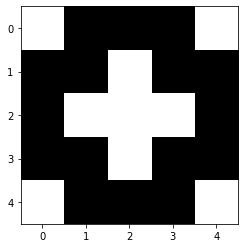

In [185]:
plt.imshow(1-np.vectorize(value)(v), cmap='gray', interpolation='none');